### 1. 언더샘플링과 오버 샘플링의 이해

__레이블이 불균형한 분포__ 를 가진 데이터 세트를 학습시킬 때 발생하는 문제를 해결하기 위한 방식.  
정상 레이블이 이상 레이블보다 과도하게 많으면 알고리즘은 __정상 레이블만 제대로 학습__ 하기 때문에 이상 데이터 학습에 실패함

__언더 샘플링__
> 많은 데이터 세트를 적은 데이터 세트 수준으로 __감소__ 시키는 방법. 정상 데이터가 100000건, 이상 데이터가 100건이면 정상 데이터를 100건으로 줄여버림  
하지만 이 경우 __데이터의 절대 수가 줄어들어__ 예측에 오히려 방해가 되므로 잘 사용하지 않음

__오버 샘플링__
> 적은 데이터 세트를 __증식__ 하여 학습을 위한 충분한 데이터를 확보하는 방법  
동일 데이터를 단순히 복붙하면 과적합이 생기므로 __K 최근접 이웃 방식__ 을 활용하여 기존 이상데이터와 약간 다른 이상데이터를 생성  
대표적으로 __SMOTE__ (Synthetic Minority Over-sampling Technique) 방식을 사용

### 2. 캐글 신용카드 사기 검출

#### 2.1 데이터 일차 가공 및 모델 학습/예측/평가

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
card_df = pd.read_csv('../data/creditcard_train.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
def get_preprocessed_df(df):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1)
    return df_copy

In [4]:
def get_train_test_dataset(df):
    ## 인자로 입력된 dfm의 사전 데이터 가공이 완료된 복사 dfm반환
    df_copy = get_preprocessed_df(df)
    ## dfm의 맨 마지막 칼럼이 레이블, 나머지는 피처
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    ## train_test_split()으로 학습과 테스트 데이터 분할. stratify = y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0, stratify = y_target)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [5]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)

print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [6]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [7]:
## 로지스틱 회귀와 LightGBM 기반의 모델로 학습/예측/평가

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

## 3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85259    36]
 [   57    91]]
정확도: 0.9989, 정밀도: 0.7165, 재현율: 0.6149,    F1: 0.6618, AUC:0.9068


In [8]:
## 학습/예측/평가 를 수행하는 함수

def get_model_train_eval(model, ftr_train, ftr_test, tgt_train, tgt_test):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [9]:
# 신용카드 사기 검출 데이터처럼 레이블이 불균형한 경우 lightGBM의 파라미터 boost_from_average = False를 지정해줄 것

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

오차 행렬
[[85291     4]
 [   34   114]]
정확도: 0.9996, 정밀도: 0.9661, 재현율: 0.7703,    F1: 0.8571, AUC:0.9769


|모델명|정확도|정밀도|재현율|F1|AUC|
|:------|:---|:---|:---|:---|:---|
|로지스틱회귀|0.9989|0.7165|0.6149|0.6618|0.9068|
|LightGBM|0.9996|0.9661|0.7703|0.8571|0.9769|

#### 2.2 데이터 분포도 변환 후 모델 학습/예측/평가

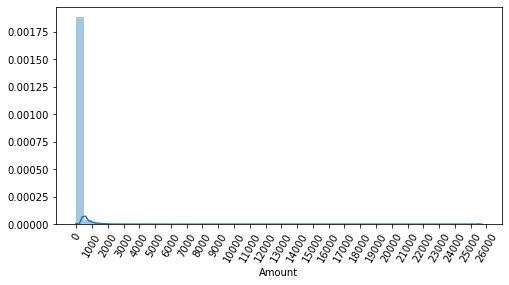

In [10]:
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount'])

In [11]:
# 레이블 값이 불균형하게 분포되었으면 회귀 알고리즘은 성능이 떨어짐 -> Amount값 정규화

def get_preprocessed_df(df):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경후 dfm 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    return df_copy

In [12]:
## Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱회귀 예측 성능')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### 로지스틱회귀 예측 성능
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능
오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568,    F1: 0.8421, AUC:0.9773


In [13]:
# StandardScaLer 대신 로그변환으로 Amount값 정규화

def get_preprocessed_df(df):
    df_copy = df.copy()
    # 넘파이의 log1p를 이용하여 Amount를 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    return df_copy

In [14]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱회귀 예측 성능')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### 로지스틱회귀 예측 성능
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9786


#### 2.4 이상치 데이터 제거 후 모델 학습/예측/평가

__이상치데이터(Outlier)__ : 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터. 머신러닝 모델의 성능에 영향을 받는 경우가 발생하기 때문에 제거하는 것이 좋음

__사분위수(IQR)__ : 이상치를 찾아내는 방식. __1Q - 1.5*IQR ~ 3Q + 1.5IQR__ 을 벗어나는 데이터를 이상치로 간주 -> boxplot을 통해 시각화
- 만약 너무 많은 칼럼이 있다면 결정값과 가장 상관성이 높은 피처들을 위주로 이상치를 검출하는 것이 바람직함

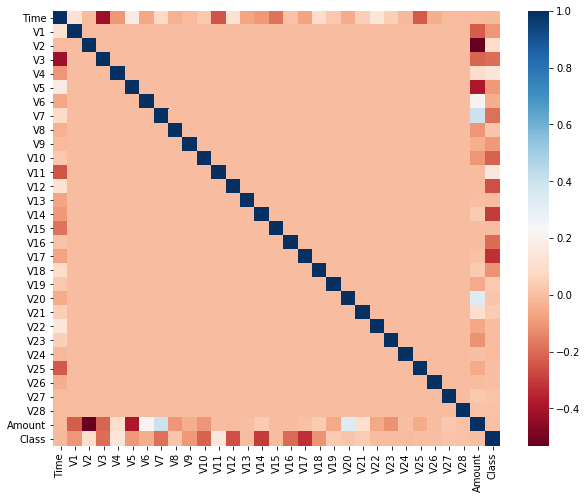

In [15]:
plt.figure(figsize=(10,8))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

색이 진할수록 __결정레이블(Class)__ 과 상관계수가 높음 = 관련도가 높음
- V12, V14, V17의 상관도가 높다

In [16]:
# 이상치를 제거하는 함수
def get_outlier(df, columns, weight):
    
    # 결정 레이블이 1인 값의 이상치를 구함.
    fraud = df[df['Class'] == 1][columns]
    q1 = np.percentile(fraud.values, 25)
    q3 = np.percentile(fraud.values, 75)

    iqr = q3 - q1
    iqr_weight = weight * iqr

    lowest_value = q1 - iqr_weight
    highest_value = q3 + iqr_weight

    outlier_index = fraud[(fraud < lowest_value) | (fraud > highest_value)].index
    return outlier_index

In [17]:
outlier_index = get_outlier(card_df, 'V14', 1.5)
print('이상치 데이터 인덱스 : ', outlier_index)

이상치 데이터 인덱스 :  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [18]:
# get_processed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경

def get_preprocessed_df(df):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)

    outlier_index = get_outlier(df_copy, 'V14', 1.5)
    df_copy.drop(outlier_index, axis=0, inplace = True)
    return df_copy

In [19]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱회귀 예측 성능')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('### LightGBM 예측 성능')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

### 로지스틱회귀 예측 성능
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능
오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288,    F1: 0.8930, AUC:0.9831


#### 2.5 SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

__SMOTE 사용시 주의사항__ : 반드시 학습 데이터 세트만 SMOTE를 통해 복사할것!!

In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', y_train_over.value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 1    199020
0    199020
Name: Class, dtype: int64


사기 데이터의 개수가 그렇지 않은 데이터와 동일

In [21]:
## 로지스틱 회귀 모델을 학습한 뒤 성능을 평가해 보기

lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


정밀도 5.12% 로는 실무에 적용 불가능 -> 실제보다 너무 많은 사기 데이터로 학습하다보니 어쩔수 없이 생기는 문제

In [22]:
# 정밀도 재현율 곡선 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    ## threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    ## X축을 threshold값으로, Y축을 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    ## threshold값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    ## x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

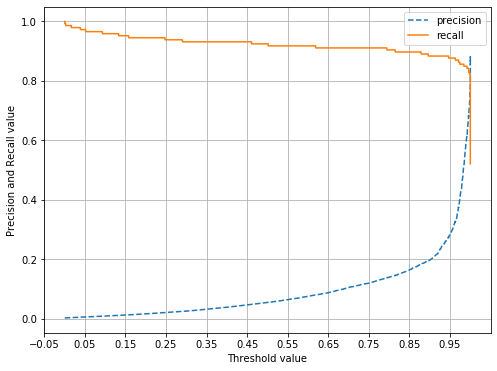

In [23]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

모델이 너무 민감해 임계값을 조정하기도 애매 -> 로지스틱회귀로는 해당 데이터를 평가하기에 무리가 있음

In [24]:
## lgbm으로 학습한 후 예측성능을 비교해보자

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average = False)
get_model_train_eval(lgbm_clf, X_train_over, X_test, y_train_over, y_test)

오차 행렬
[[85286     9]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9323, 재현율: 0.8493,    F1: 0.8889, AUC:0.9789


일반적으로 SMOTE를 적용하면 __재현율은 높아지나 정밀도는 낮아지는 경향__ 이 있음 -> SMOTE 패키지의 성능에 따라서 상승률이 더 커지고 하락률이 더 줄어듬